In [1]:
# Install the necessary libraries
!pip install gdown

# Download the dataset zip file from Google Drive
!gdown --id 16cD3PPAF3MlaX6QZg24H0vKSguv-S8ZV -O dataset.zip

/opt/conda/lib/python3.7/site-packages/gdown/cli.py:125: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=16cD3PPAF3MlaX6QZg24H0vKSguv-S8ZV
To: /kaggle/working/dataset.zip
100%|███████████████████████████████████████| 2.94G/2.94G [00:18<00:00, 163MB/s]


In [2]:
!unzip "/kaggle/working/dataset.zip"

Archive:  /kaggle/working/dataset.zip
   creating: DATASET/PNEUMONIA_NEGATIVE/
  inflating: DATASET/PNEUMONIA_NEGATIVE/00000002_000.png  
  inflating: DATASET/PNEUMONIA_NEGATIVE/00000005_000.png  
  inflating: DATASET/PNEUMONIA_NEGATIVE/00000005_001.png  
  inflating: DATASET/PNEUMONIA_NEGATIVE/00000005_002.png  
  inflating: DATASET/PNEUMONIA_NEGATIVE/00000005_003.png  
  inflating: DATASET/PNEUMONIA_NEGATIVE/00000005_004.png  
  inflating: DATASET/PNEUMONIA_NEGATIVE/00000005_005.png  
  inflating: DATASET/PNEUMONIA_NEGATIVE/00000006_000.png  
  inflating: DATASET/PNEUMONIA_NEGATIVE/00000007_000.png  
  inflating: DATASET/PNEUMONIA_NEGATIVE/00000008_001.png  
  inflating: DATASET/PNEUMONIA_NEGATIVE/00000011_001.png  
  inflating: DATASET/PNEUMONIA_NEGATIVE/00000011_002.png  
  inflating: DATASET/PNEUMONIA_NEGATIVE/00000011_003.png  
  inflating: DATASET/PNEUMONIA_NEGATIVE/00000011_004.png  
  inflating: DATASET/PNEUMONIA_NEGATIVE/00000011_008.png  
  inflating: DATASET/PNEUMONIA_NEGAT

In [3]:
import os
import numpy as np
import random
import cv2
from sklearn.model_selection import train_test_split

# Define the directory paths for the positive and negative pneumonia images
pneumonia_positive_dir = '/kaggle/working/DATASET/PNEUMONIA_POSITIVE'
pneumonia_negative_dir = '/kaggle/working/DATASET/PNEUMONIA_NEGATIVE'

# Define the image size
img_size = 224

# Create empty arrays to store the images and labels
images = []
labels = []

# Load the positive pneumonia images
for filename in os.listdir(pneumonia_positive_dir):
    img = cv2.imread(os.path.join(pneumonia_positive_dir, filename))
    img = cv2.resize(img, (img_size, img_size))
    images.append(img)
    labels.append(1)  # Positive label

# Load the negative pneumonia images
for filename in os.listdir(pneumonia_negative_dir):
    img = cv2.imread(os.path.join(pneumonia_negative_dir, filename))
    img = cv2.resize(img, (img_size, img_size))
    images.append(img)
    labels.append(0)  # Negative label

# Convert the images and labels to numpy arrays
images = np.array(images)
labels = np.array(labels)

# Shuffle the dataset
random.seed(42)
idx = np.arange(len(images))
random.shuffle(idx)
images = images[idx]
labels = labels[idx]

# Divide the dataset into training, testing, and validation sets using an 80/10/10 split
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.1, random_state=42, stratify=labels)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1111, random_state=42, stratify=y_train)

# Print the size of each set
print("Training set size:", X_train.shape[0])
print("Validation set size:", X_val.shape[0])
print("Testing set size:", X_test.shape[0])


Training set size: 8000
Validation set size: 1000
Testing set size: 1000


In [4]:
from keras.preprocessing.image import ImageDataGenerator

# Define the augmentation parameters
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = True,  # randomly flip images
        vertical_flip=False ) # randomly flip the image vertically

# Create the training generator
train_generator = datagen.flow(X_train, y_train, batch_size=32)


In [5]:
import tensorflow 
from tensorflow.keras.layers import Conv2D, Flatten, MaxPooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential

In [6]:
from keras.applications import VGG16

# Load the VGG16 model
base_model = VGG16(input_shape=(img_size, img_size, 3), include_top=False, weights='imagenet')

# Freeze the convolutional layers
for layer in base_model.layers:
    layer.trainable = False

# Build the model
model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


58889256/58889256 [==============================] - 2s 0us/step


In [7]:
history = model.fit_generator(train_generator, epochs = 25, validation_data = (X_val, y_val), steps_per_epoch = 100)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  """Entry point for launching an IPython kernel.


Epoch 1/25
100/100 [==============================] - 47s 369ms/step - loss: 3.4419 - accuracy: 0.8716 - val_loss: 0.2505 - val_accuracy: 0.8770
Epoch 2/25
100/100 [==============================] - 36s 362ms/step - loss: 0.2189 - accuracy: 0.9131 - val_loss: 0.1756 - val_accuracy: 0.9340
Epoch 3/25
100/100 [==============================] - 36s 358ms/step - loss: 0.2263 - accuracy: 0.9234 - val_loss: 0.1682 - val_accuracy: 0.9270
Epoch 4/25
100/100 [==============================] - 36s 355ms/step - loss: 0.2032 - accuracy: 0.9281 - val_loss: 0.1323 - val_accuracy: 0.9600
Epoch 5/25
100/100 [==============================] - 35s 353ms/step - loss: 0.2064 - accuracy: 0.9347 - val_loss: 0.2355 - val_accuracy: 0.8990
Epoch 6/25
100/100 [==============================] - 36s 361ms/step - loss: 0.1776 - accuracy: 0.9306 - val_loss: 0.2462 - val_accuracy: 0.9010
Epoch 7/25
100/100 [==============================] - 36s 362ms/step - loss: 0.1738 - accuracy: 0.9253 - val_loss: 0.1482 - val_ac

In [8]:
test_loss, test_accuracy = model.evaluate(X_test, y_test, steps = 50)
print("The testing accuracy is: ", test_accuracy * 100, "%")
print("The testing loss is: ", test_loss * 100, "%")

50/50 [==============================] - 5s 53ms/step - loss: 0.0741 - accuracy: 0.9780
The testing accuracy is:  97.79999852180481 %
The testing loss is:  7.40688294172287 %


In [9]:
# Load your trained model into a variable called "model"
# Assuming that your model has already been compiled and trained on the training set

# Predict labels for the test set
y_pred = model.predict(X_test)

# Convert the predicted probabilities to binary labels (0 or 1) using a threshold of 0.5
y_pred_binary = (y_pred >= 0.5).astype(int)

# Count the number of positives and negatives
num_positives = np.sum(y_pred_binary)
num_negatives = len(y_pred_binary) - num_positives

print("Number of predicted positives:", num_positives)
print("Number of predicted negatives:", num_negatives)


32/32 [==============================] - 2s 58ms/step
Number of predicted positives: 417
Number of predicted negatives: 583


In [10]:
print(y_pred[0])
print(y_pred[1])
print(y_pred[2])
print(y_pred[3])
print(y_pred[4])

[1.777328e-05]
[0.00375153]
[0.9999274]
[0.99977654]
[0.99653673]


In [11]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score


# Predict on the test set
preds = model.predict(X_test)
y_pred = []
for prob in preds:
    if prob >= 0.5:
        y_pred.append(1)
    else:
        y_pred.append(0)

y_pred = np.array(y_pred)

# Calculate accuracy, precision, and recall
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print('Accuracy: {:.4f}'.format(accuracy))
print('Precision: {:.4f}'.format(precision))
print('Recall: {:.4f}'.format(recall))

32/32 [==============================] - 2s 58ms/step
Accuracy: 0.9780
Precision: 0.9856
Recall: 0.9625


32/32 [==============================] - 2s 58ms/step



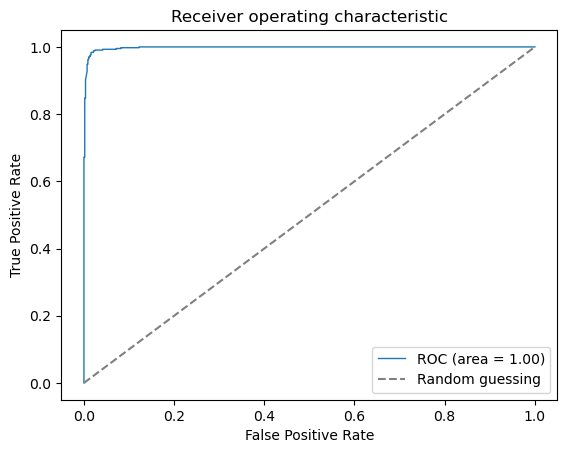

In [12]:
from sklearn.metrics import roc_curve, auc
from keras.models import load_model
import matplotlib.pyplot as plt

# Make predictions on the test set
y_pred = model.predict(X_test)

# Compute the ROC curve and area under the curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

print()
# Plot the ROC curve
plt.plot(fpr, tpr, lw=1, label='ROC (area = %0.2f)' % (roc_auc))
plt.plot([0, 1], [0, 1], '--', color='gray', label='Random guessing')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [13]:
import random
import matplotlib.pyplot as plt
import numpy as np


def random_image_prediction():
  # Load the image
  import os
  image_names = os.listdir('/kaggle/working/DATASET/PNEUMONIA_POSITIVE')

  # Select a random image file
  random_file = random.choice(image_names)

  # Load the image using the `cv2.imread()` function
  image = cv2.imread("/kaggle/working/DATASET/PNEUMONIA_POSITIVE/" + random_file)

  # Resize the image
  image = cv2.resize(image, (224, 224))

  # Reshape the image to have a batch dimension
  image = np.expand_dims(image, axis=0)

  # Make predictions on the image
  pred = model.predict(image)

  # Print the predicted probability of the positive class
  print(pred[0][0])

  if (pred[0][0] > 0.5):
    print("Positive")
  else:
    print("Negative")


print('1.')
random_image_prediction()
print('')
print('2.')
random_image_prediction()
print('') 
print('3.')
random_image_prediction()


1.
1/1 [==============================] - 0s 258ms/step
0.9999993
Positive

2.
1/1 [==============================] - 0s 20ms/step
0.99998116
Positive

3.
1/1 [==============================] - 0s 21ms/step
0.9629217
Positive


In [14]:
import random
import matplotlib.pyplot as plt
import numpy as np


def random_image_prediction():
  # Load the image
  import os
  image_names = os.listdir('/kaggle/working/DATASET/PNEUMONIA_NEGATIVE')

  # Select a random image file
  random_file = random.choice(image_names)

  # Load the image using the `cv2.imread()` function
  image = cv2.imread("/kaggle/working/DATASET/PNEUMONIA_NEGATIVE/" + random_file)

  # Resize the image
  image = cv2.resize(image, (224, 224))

  # Reshape the image to have a batch dimension
  image = np.expand_dims(image, axis=0)

  # Make predictions on the image
  pred = model.predict(image)

  # Print the predicted probability of the positive class
  print(pred[0][0])

  if (pred[0][0] > 0.5):
    print("Positive")
  else:
    print("Negative")


print('1.')
random_image_prediction()
print('')
print('2.')
random_image_prediction()
print('') 
print('3.')
random_image_prediction()


1.
1/1 [==============================] - 0s 19ms/step
3.9921437e-05
Negative

2.
1/1 [==============================] - 0s 18ms/step
3.0651634e-07
Negative

3.
1/1 [==============================] - 0s 19ms/step
8.050052e-14
Negative


In [16]:
model.save("P_VGG16_Model.h5")